Uvozimo pakete

In [1]:
import main
import pandas as pd
# import spremenljivke
from spremenljivke import *


Pridobimo željene podatke

In [2]:
main.main(True, True, 1, 1)

v procesu pridobivanja html-ja
stran 1
v procesu pridobivanja posatkov iz htmlja v csv
končano


Poglejmo si razpredelnivco pridobljenih podatkov

In [3]:
razpredelnica

,ime,oblika,vrsta,tonemski_naglas
0,á,--,samostalnik moškega spola,ā
1,à,à,samostalnik moškega spola,ȃ
2,abalienácija,-e,samostalnik ženskega spola,á
3,abalienacíjski,-a -o,pridevnik,ȋ
4,abbé,-ja,samostalnik moškega spola,ẹ̑ ȇ
...,...,...,...,...
20637,adhezívnost,-i,samostalnik ženskega spola,ȋ
20638,ad hoc,-e,samostalnik ženskega spola,ȃ
20639,adiabáten,-tna -o,pridevnik,ȃ
20640,adiabátičen,-čna -o,pridevnik,á


In [28]:
število_vrste = razpredelnica.groupby("vrsta")[["ime"]].agg("count")
število_vrste

,ime
vrsta,
dovršni glagol,269
dovršni in nedovršni glagol,380
nedovršni glagol,1012
pridevnik,5174
prislov,54
samostalnik moškega spola,6340
samostalnik srednjega spola,1552
samostalnik ženskega spola,5849
členek,12


In [55]:
def štetje_vrst(razpredelnica):
    število_vrste = razpredelnica.groupby("vrsta")[["ime"]].agg("count")
    število_vrste.rename(columns={"ime": "število"}, inplace=True)
    # število_vrste.index.names = ['vrsta']
    # število_vrste.set_index("vrsta")
    # število_vrste.loc["dovršni glagol"] += število_vrste.loc["dovršni in nedovršni glagol"]
    # število_vrste.loc["nedovršni glagol"] += število_vrste.loc["dovršni in nedovršni glagol"]
    # število_vrste.drop("dovršni in nedovršni glagol", inplace=True)
    
    število = število_vrste.loc["dovršni glagol"] +število_vrste.loc["nedovršni glagol"] + število_vrste.loc["dovršni in nedovršni glagol"]
    število_vrste = pd.concat([pd.DataFrame({"število":število}), število_vrste])
    število_vrste.drop("dovršni glagol", inplace=True)
    število_vrste.drop("nedovršni glagol", inplace=True)
    število_vrste.drop("dovršni in nedovršni glagol", inplace=True)
    
    
    
    return število_vrste
štetje_vrst(razpredelnica)

KeyError: "None of ['vrsta'] are in the columns"

<Axes: xlabel='vrsta'>

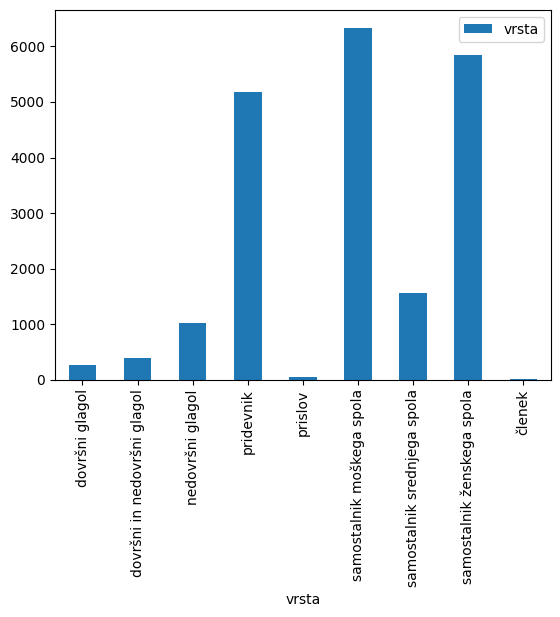

In [5]:
število_vrste.plot.bar()

In [6]:
ženski_samostalniki = razpredelnica.loc[razpredelnica["vrsta"] == "samostalnik ženskega spola"]
moški_samostalniki = razpredelnica.loc[razpredelnica["vrsta"] == "samostalnik moškega spola"]
srednji_samostalniki = razpredelnica.loc[razpredelnica["vrsta"] == "samostalnik srednjega spola"]

razpredelnica_samostalnikov = pd.concat([ženski_samostalniki, moški_samostalniki, srednji_samostalniki])
razpredelnica_samostalnikov

,ime,oblika,vrsta,tonemski_naglas
2,abalienácija,-e,samostalnik ženskega spola,á
9,abdikácija,-e,samostalnik ženskega spola,á
12,abdúkcija,-e,samostalnik ženskega spola,ú
13,abece,-e,samostalnik ženskega spola,ẹ̑
17,abecédarica,-e,samostalnik ženskega spola,ẹ̑
...,...,...,...,...
20498,abecédniški,-a -o,samostalnik srednjega spola,ā
20565,absolutizíranje,-a,samostalnik srednjega spola,ȋ
20572,absorbíranje,-a,samostalnik srednjega spola,ȋ
20580,abstinêntski,abstinéntski -a -o,samostalnik srednjega spola,ē; ẹ̄
